# Network Intrusion Dection 

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from pandas.api.types import is_numeric_dtype
import warnings
import optuna
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree  import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import BernoulliNB
#from lightgbm import LGBMClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import average_precision_score, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, precision_recall_curve

import itertools
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from tabulate import tabulate
import os
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)


# Data Background

The dataset to be audited was provided which consists of a wide variety of intrusions simulated in a military network environment. It created an environment to acquire raw TCP/IP dump data for a network by simulating a typical US Air Force LAN. The LAN was focused like a real environment and blasted with multiple attacks. 

A connection is a sequence of TCP packets starting and ending at some time duration between which data flows to and from a source IP address to a target IP address under some well-defined protocol. 

Also, each connection is labelled as either normal or as an attack with exactly one specific attack type. Each connection record consists of about 100 bytes.

For each TCP/IP connection, 41 quantitative and qualitative features are obtained from normal and attack data (3 qualitative and 38 quantitative features) .The class variable has two categories:

• Normal

• Anomalous

# Data Preprocessing & EDA

In [7]:
train=pd.read_csv('data/Train_data.csv')
test=pd.read_csv('data/Test_data.csv')
train

duration protocol_type   service  flag  src_bytes  dst_bytes  land  \
0             0           tcp  ftp_data    SF        491          0     0   
1             0           udp     other    SF        146          0     0   
2             0           tcp   private    S0          0          0     0   
3             0           tcp      http    SF        232       8153     0   
4             0           tcp      http    SF        199        420     0   
...         ...           ...       ...   ...        ...        ...   ...   
25187         0           tcp      exec  RSTO          0          0     0   
25188         0           tcp  ftp_data    SF        334          0     0   
25189         0           tcp   private   REJ          0          0     0   
25190         0           tcp      nnsp    S0          0          0     0   
25191         0           tcp    finger    S0          0          0     0   

       wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0                   0       0    0  ...                  25   
1                   0       0    0  ...                   1   
2                   0       0    0  ...                  26   
3                   0       0    0  ...                 255   
4                   0       0    0  ...                 255   
...               ...     ...  ...  ...                 ...   
25187               0       0    0  ...                   7   
25188               0       0    0  ...                  39   
25189               0       0    0  ...                  13   
25190               0       0    0  ...                  20   
25191               0       0    0  ...                  49   

       dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                        0.17                    0.03   
1                        0.00                    0.60   
2                        0.10                    0.05   
3                        1.00                    0.00   
4                        1.00                    0.00   
...                       ...                     ...   
25187                    0.03                    0.06   
25188                    1.00                    0.00   
25189                    0.05                    0.07   
25190                    0.08                    0.06   
25191                    0.19                    0.03   

       dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
0                             0.17                         0.00   
1                             0.88                         0.00   
2                             0.00                         0.00   
3                             0.03                         0.04   
4                             0.00                         0.00   
...                            ...                          ...   
25187                         0.00                         0.00   
25188                         1.00                         0.18   
25189                         0.00                         0.00   
25190                         0.00                         0.00   
25191                         0.01                         0.00   

       dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
0                      0.00                      0.00                  0.05   
1                      0.00                      0.00                  0.00   
2                      1.00                      1.00                  0.00   
3                      0.03                      0.01                  0.00   
4                      0.00                      0.00                  0.00   
...                     ...                       ...                   ...   
25187                  0.00                      0.00                  1.00   
25188                  0.00                      0.00                  0.00   
25189                  0.00                      0.00                  1.00   
25190                  1.00                  

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25192 entries, 0 to 25191
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     25192 non-null  int64  
 1   protocol_type                25192 non-null  object 
 2   service                      25192 non-null  object 
 3   flag                         25192 non-null  object 
 4   src_bytes                    25192 non-null  int64  
 5   dst_bytes                    25192 non-null  int64  
 6   land                         25192 non-null  int64  
 7   wrong_fragment               25192 non-null  int64  
 8   urgent                       25192 non-null  int64  
 9   hot                          25192 non-null  int64  
 10  num_failed_logins            25192 non-null  int64  
 11  logged_in                    25192 non-null  int64  
 12  num_compromised              25192 non-null  int64  
 13  root_shell      

In [9]:
train.head()

duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                  25   
1               0       0    0  ...                   1   
2               0       0    0  ...                  26   
3               0       0    0  ...                 255   
4               0       0    0  ...                 255   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.17                    0.03   
1                    0.00                    0.60   
2                    0.10                    0.05   
3                    1.00                    0.00   
4                    1.00                    0.00   

   dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
0                         0.17                         0.00   
1                         0.88                         0.00   
2                         0.00                         0.00   
3                         0.03                         0.04   
4                         0.00                         0.00   

   dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
0                  0.00                      0.00                  0.05   
1                  0.00                      0.00                  0.00   
2                  1.00                      1.00                  0.00   
3                  0.03                      0.01                  0.00   
4                  0.00                      0.00                  0.00   

   dst_host_srv_rerror_rate    class  
0                      0.00   normal  
1                      0.00   normal  
2                      0.00  anomaly  
3                      0.01   normal  
4                      0.00   normal  

[5 rows x 42 columns]

In [10]:
train.describe()

duration     src_bytes     dst_bytes          land  wrong_fragment  \
count  25192.000000  2.519200e+04  2.519200e+04  25192.000000    25192.000000   
mean     305.054104  2.433063e+04  3.491847e+03      0.000079        0.023738   
std     2686.555640  2.410805e+06  8.883072e+04      0.008910        0.260221   
min        0.000000  0.000000e+00  0.000000e+00      0.000000        0.000000   
25%        0.000000  0.000000e+00  0.000000e+00      0.000000        0.000000   
50%        0.000000  4.400000e+01  0.000000e+00      0.000000        0.000000   
75%        0.000000  2.790000e+02  5.302500e+02      0.000000        0.000000   
max    42862.000000  3.817091e+08  5.151385e+06      1.000000        3.000000   

            urgent           hot  num_failed_logins     logged_in  \
count  25192.00000  25192.000000       25192.000000  25192.000000   
mean       0.00004      0.198039           0.001191      0.394768   
std        0.00630      2.154202           0.045418      0.488811   
min        0.00000      0.000000           0.000000      0.000000   
25%        0.00000      0.000000           0.000000      0.000000   
50%        0.00000      0.000000           0.000000      0.000000   
75%        0.00000      0.000000           0.000000      1.000000   
max        1.00000     77.000000           4.000000      1.000000   

       num_compromised  ...  dst_host_count  dst_host_srv_count  \
count     25192.000000  ...    25192.000000        25192.000000   
mean          0.227850  ...      182.532074          115.063036   
std          10.417352  ...       98.993895          110.646850   
min           0.000000  ...        0.000000            0.000000   
25%           0.000000  ...       84.000000           10.000000   
50%           0.000000  ...      255.000000           61.000000   
75%           0.000000  ...      255.000000          255.000000   
max         884.000000  ...      255.000000          255.000000   

       dst_host_same_srv_rate  dst_host_diff_srv_rate  \
count            25192.000000            25192.000000   
mean                 0.519791                0.082539   
std                  0.448944                0.187191   
min                  0.000000                0.000000   
25%                  0.050000                0.000000   
50%                  0.510000                0.030000   
75%                  1.000000                0.070000   
max                  1.000000                1.000000   

       dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
count                 25192.000000                 25192.000000   
mean                      0.147453                     0.031844   
std                       0.308367                     0.110575   
min                       0.000000                     0.000000   
25%                       0.000000                     0.000000   
50%                       0.000000                     0.000000   
75%                       0.060000                     0.020000   
max                       1.000000                     1.000000   

       dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
count          25192.000000              25192.000000          25192.000000   
mean               0.285800                  0.279846              0.117800   
std                0.445316                  0.446075              0.305869   
min                0.000000                  0.000000              0.000000   
25%                0.000000                  0.000000              0.000000   
50%                0.000000                  0.000000              0.000000   
75%                1.000000                  1.000000              0.000000   
max                1.000000                  1.000000              1.000000   

       dst_host_srv_rerror_rate  
count              25192.000000  
mean                   0.118769  
std                    0.317333  
min                    0.000000  
25%                    0.000000  
50%                  

In [11]:
train.describe(include='object')

protocol_type service   flag   class
count          25192   25192  25192   25192
unique             3      66     11       2
top              tcp    http     SF  normal
freq           20526    8003  14973   13449

# Missing Data 

In [12]:
total = train.shape[0]
missing_columns = [col for col in train.columns if train[col].isnull().sum() > 0]
for col in missing_columns:
    null_count = train[col].isnull().sum()
    per = (null_count/total) * 100
    print(f"{col}: {null_count} ({round(per, 3)}%)")

# Duplicates 

In [13]:
print(f"Number of duplicate rows: {train.duplicated().sum()}")

Number of duplicate rows: 0


# Correlations

<AxesSubplot:>

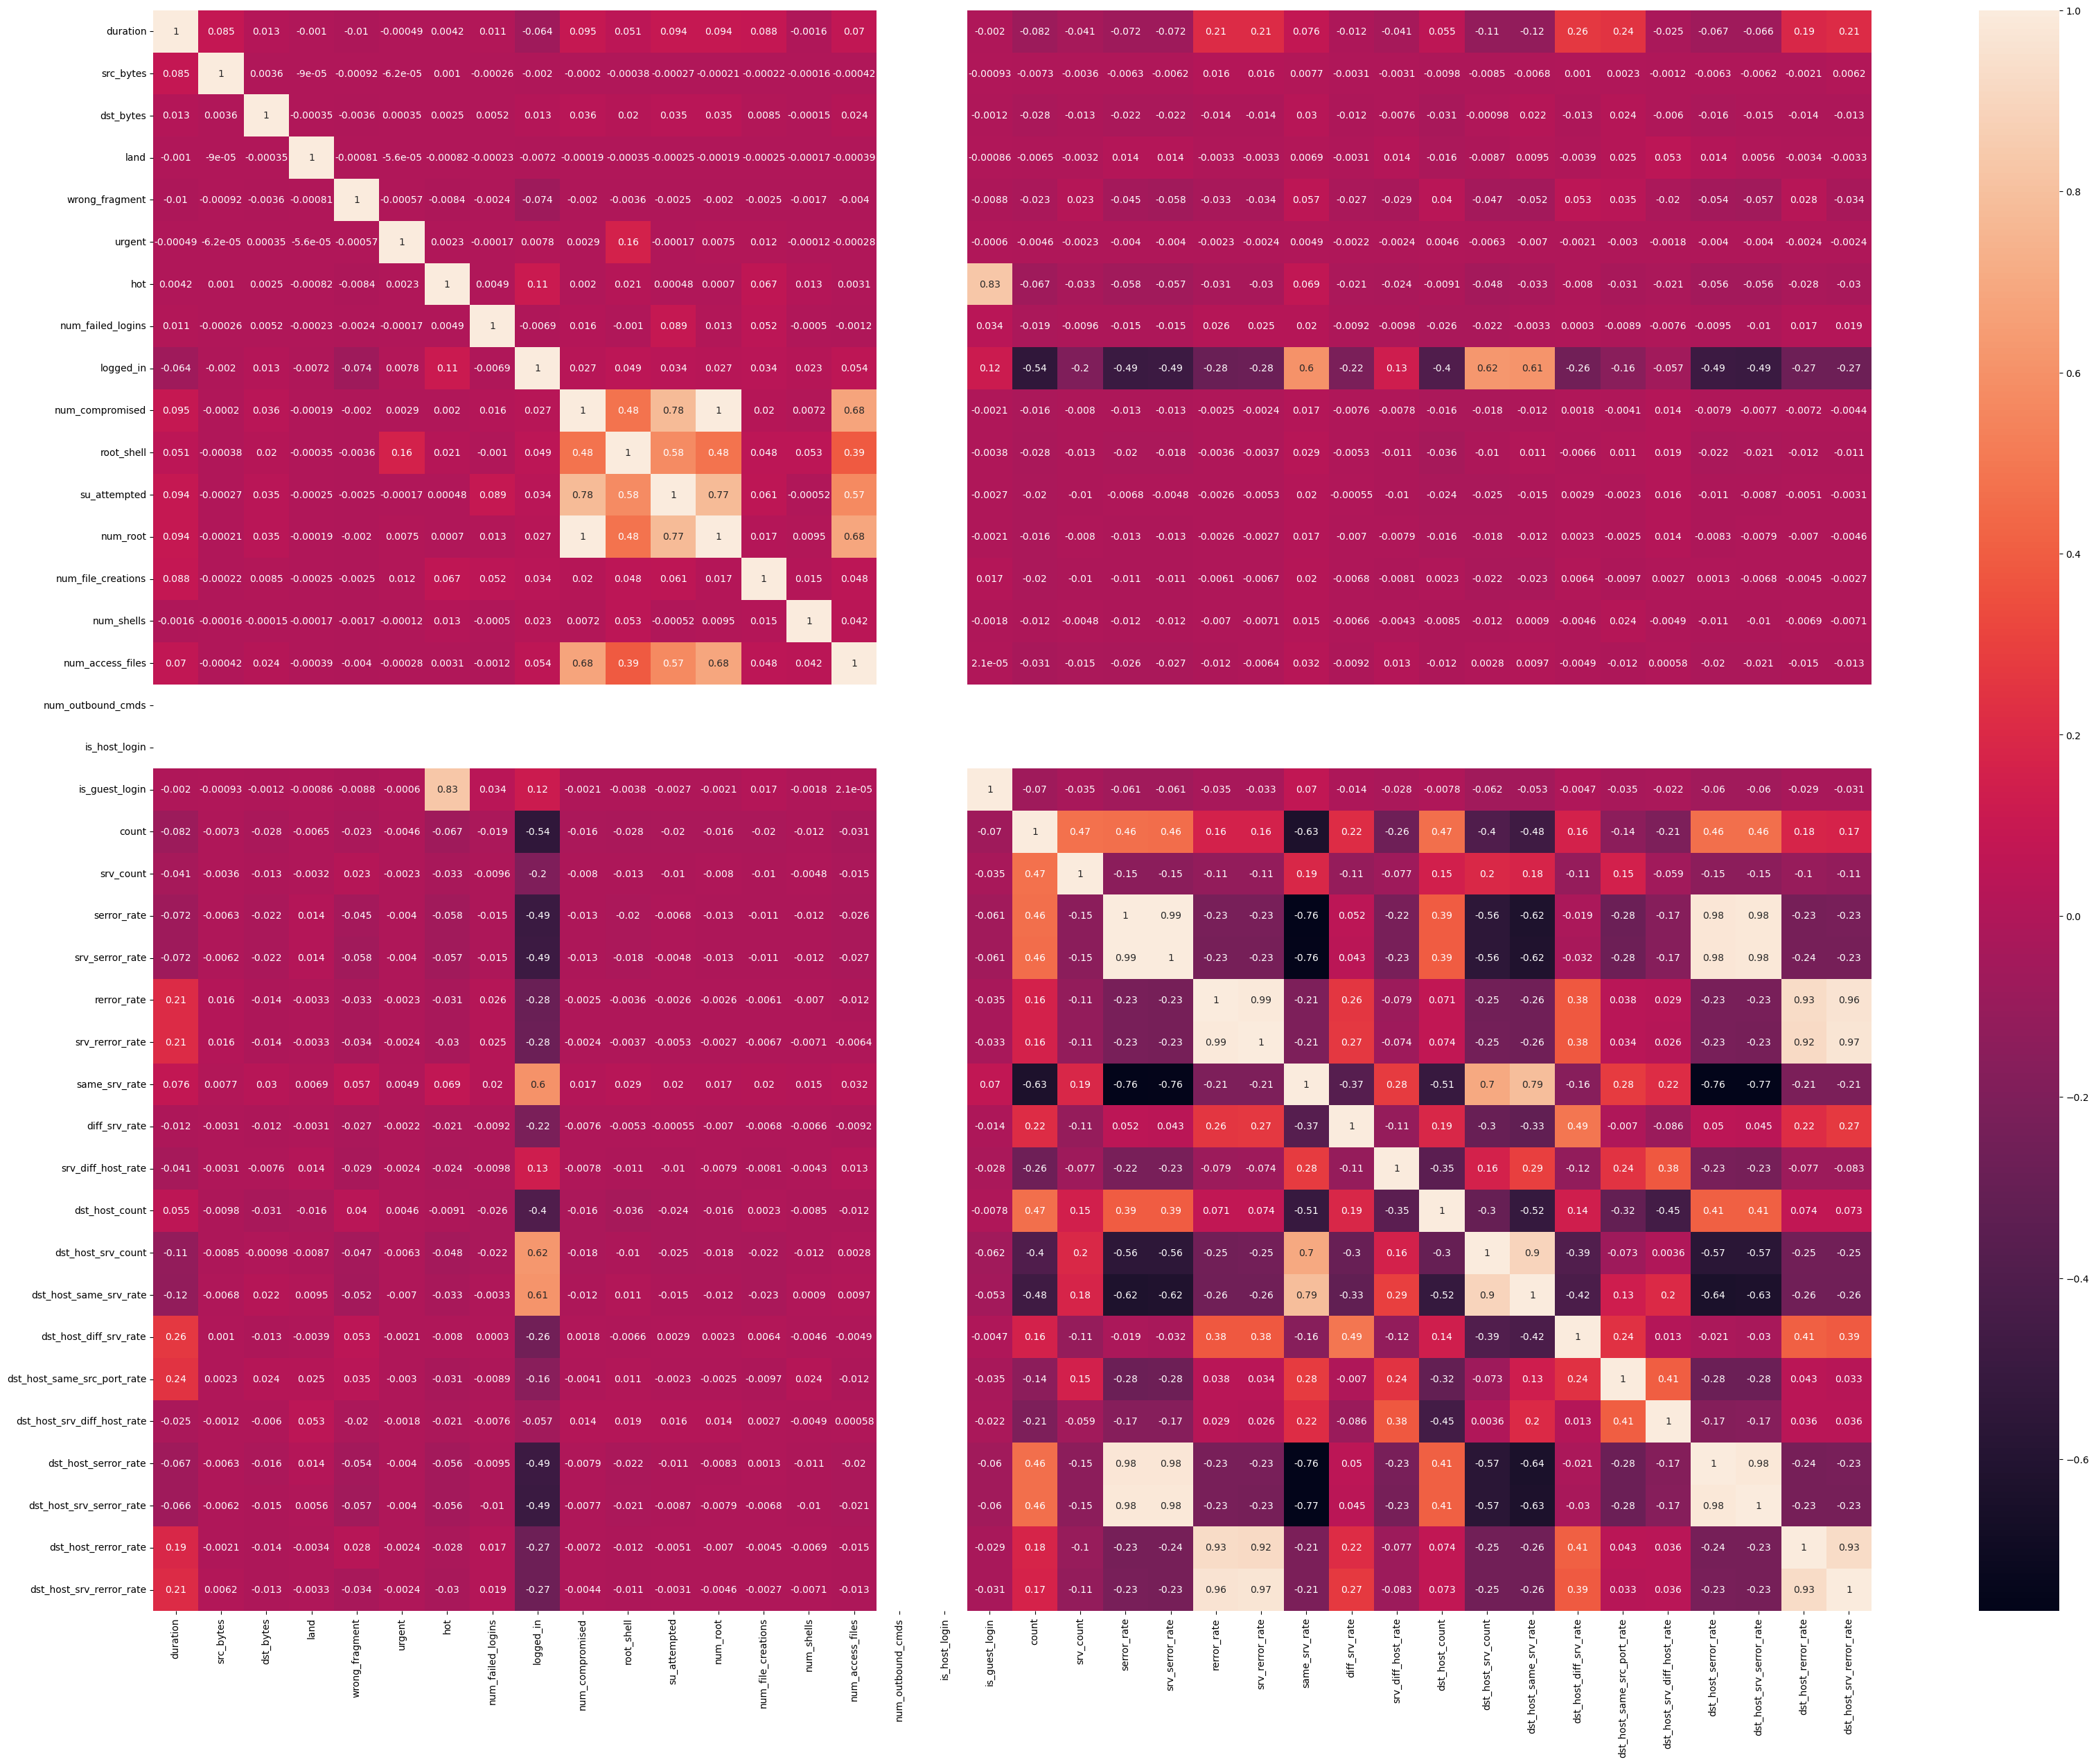

In [14]:
plt.figure(figsize=(40,30))
sns.heatmap(train.corr(), annot=True)

<AxesSubplot:xlabel='class', ylabel='count'>

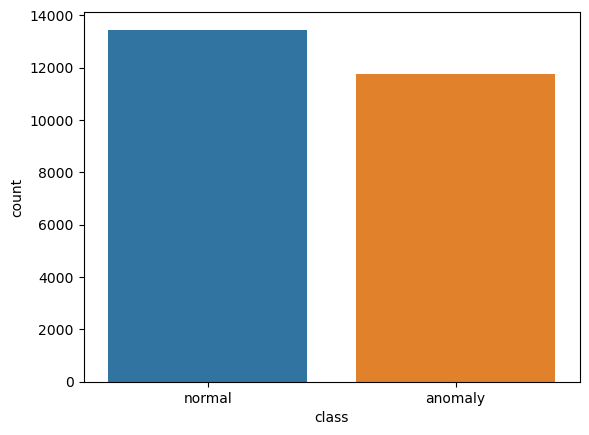

In [15]:
sns.countplot(x=train['class'])


# Label Encoding 

In [16]:
def le(df):
    for col in df.columns:
        if df[col].dtype == 'object':
                label_encoder = LabelEncoder()
                df[col] = label_encoder.fit_transform(df[col])

le(train)
le(test)

In [17]:
train.drop(['num_outbound_cmds'], axis=1, inplace=True)
test.drop(['num_outbound_cmds'], axis=1, inplace=True)
train.head()

duration  protocol_type  service  flag  src_bytes  dst_bytes  land  \
0         0              1       19     9        491          0     0   
1         0              2       41     9        146          0     0   
2         0              1       46     5          0          0     0   
3         0              1       22     9        232       8153     0   
4         0              1       22     9        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                  25   
1               0       0    0  ...                   1   
2               0       0    0  ...                  26   
3               0       0    0  ...                 255   
4               0       0    0  ...                 255   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.17                    0.03   
1                    0.00                    0.60   
2                    0.10                    0.05   
3                    1.00                    0.00   
4                    1.00                    0.00   

   dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
0                         0.17                         0.00   
1                         0.88                         0.00   
2                         0.00                         0.00   
3                         0.03                         0.04   
4                         0.00                         0.00   

   dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
0                  0.00                      0.00                  0.05   
1                  0.00                      0.00                  0.00   
2                  1.00                      1.00                  0.00   
3                  0.03                      0.01                  0.00   
4                  0.00                      0.00                  0.00   

   dst_host_srv_rerror_rate  class  
0                      0.00      1  
1                      0.00      1  
2                      0.00      0  
3                      0.01      1  
4                      0.00      1  

[5 rows x 41 columns]

# Feature Selection 

In [18]:
X_train = train.drop(['class'], axis=1)
Y_train = train['class']

In [19]:
rfc = RandomForestClassifier()

rfe = RFE(rfc, n_features_to_select=10)
rfe = rfe.fit(X_train, Y_train)

feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), X_train.columns)]
selected_features = [v for i, v in feature_map if i==True]

selected_features

['protocol_type',
 'flag',
 'src_bytes',
 'dst_bytes',
 'count',
 'same_srv_rate',
 'diff_srv_rate',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_same_src_port_rate']

In [20]:
X_train = X_train[selected_features]

# Split and Scale Data

In [21]:
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
test = scale.fit_transform(test)

In [22]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, train_size=0.70, random_state=2)

# Training Random Forest Model 

In [23]:
def objective(trial):
    rf_max_depth = trial.suggest_int('rf_max_depth', 2, 32, log=False)
    rf_max_features = trial.suggest_int('rf_max_features', 2, 10, log=False)
    rf_n_estimators = trial.suggest_int('rf_n_estimators', 3, 20, log=False)
    classifier_obj = RandomForestClassifier(max_features = rf_max_features, max_depth = rf_max_depth, n_estimators = rf_n_estimators)
    classifier_obj.fit(x_train, y_train)
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy


In [24]:
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective, n_trials=30)
print(study_rf.best_trial)

FrozenTrial(number=24, state=TrialState.COMPLETE, values=[0.9961630060862662], datetime_start=datetime.datetime(2023, 2, 1, 21, 31, 34, 151484), datetime_complete=datetime.datetime(2023, 2, 1, 21, 31, 34, 358590), params={'rf_max_depth': 28, 'rf_max_features': 5, 'rf_n_estimators': 18}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'rf_max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'rf_max_features': IntDistribution(high=10, log=False, low=2, step=1), 'rf_n_estimators': IntDistribution(high=20, log=False, low=3, step=1)}, trial_id=24, value=None)


In [25]:
rf = RandomForestClassifier(max_features = study_rf.best_trial.params['rf_max_features'], max_depth = study_rf.best_trial.params['rf_max_depth'], n_estimators = study_rf.best_trial.params['rf_n_estimators'])
rf.fit(x_train, y_train)

rf_train, rf_test = rf.score(x_train, y_train), rf.score(x_test, y_test)

print(f"Train Score: {rf_train}")
print(f"Test Score: {rf_test}")


Train Score: 0.9999432913689463
Test Score: 0.9957660756813972


# Model Prediction based on test data 

In [26]:
y_pred = rf.predict(x_test)
y_score = rf.predict_proba(x_test)[:,1]

In [27]:
accuracy = round(accuracy_score(y_test, y_pred), 4)
recall = round(recall_score(y_test, y_pred), 4)
precision = round(precision_score(y_test, y_pred), 4)
f1 = round(f1_score(y_test, y_pred), 4)
auc_pr = round(average_precision_score(y_test, y_pred), 4)

In [28]:
# Create Subplot
fig = make_subplots(
        rows=2, cols=2,
        specs=[
            [{}, {}],
            [{"colspan": 2}, None]
        ],
        subplot_titles=("Confusion Matrix", "Metric Scores", "Precision-Recall Curve (AUC: {})".format(auc_pr)),
        vertical_spacing=0.15
)

# Confusion Matrix
cn_matrix = confusion_matrix(y_test, y_pred)
fig.add_trace(
    go.Heatmap(
        z=cn_matrix,
        x=['Normal', 'Anomaly'],
        y=['Normal', 'Anomaly'],
        text=cn_matrix,
        texttemplate="<b>%{text}</b>",
        textfont={"size":18},
        colorscale=[[0, 'LightGray'],[1.0, '#406179']],
        showscale = False,
        ygap = 5,
        xgap = 5,
        hovertemplate=
        '''
        Actual: %{y}<br>
        Predicted: %{x}<br>
        Total: %{text}
        ''',
        name="Confusion Matrix"
    ), row=1, col=1
)

# Metric Scores
metrics = ['AUC', 'F1', 'Precision', 'Recall', 'Accuracy']
scores = [auc_pr, f1, precision, recall, accuracy]
scores = [round(score*100, 2) for score in scores]
list_color = ["#b2a0e8", "#b07be2", "#7e65bd", "#419db2", "#406179"]
fig.add_trace(
    go.Bar(
        x=scores,
        y=[1, 2, 3, 4, 5],
        orientation='h',
        marker_color=list_color,
        name="Scores"
    ), row=1, col=2
)

fig.add_trace(
    go.Bar(
        x=scores,
        y=[1, 2, 3, 4, 5],
        orientation='h',
        marker_color="#e6e6e6",
        hoverinfo='skip'
    ), row=1, col=2
)

# Precision-Recall Curve
precision_c, recall_c, thresholds = precision_recall_curve(y_test, y_score)
fig.add_trace(
    go.Scatter(
        x=recall_c, y=precision_c,
        name="Precision-Recall",
        line=dict(
            color="#b07be2",
            width=2
        ),
        fill='tozeroy'
    ), row=2, col=1
)

# Annotations
fig.layout.annotations[0].update(y=1.02)
fig.layout.annotations[1].update(y=1.02)
for i in range(5):
    fig.add_annotation(
        x=scores[i], y=i+1.2,
        xref='x2', yref='y2',
        text="<b>{}%<b>".format(scores[i]),
        font=dict(
            color="Black",
            size=10
        ),
        align="center",
        showarrow=True, arrowhead=2, arrowwidth=2, arrowcolor=list_color[i], ax=0, ay=-20, 
        bordercolor="#e6e6e6", borderwidth=1, borderpad=4, 
        bgcolor=list_color[i],
        opacity=0.8
    )

# Update Axes
fig.update_xaxes(title="<b>Predicted Values</b>", row=1, col=1)
fig.update_yaxes(title="<b>Actual Values</b>", row=1, col=1)

fig.update_xaxes(title_text="", range=[0, 100], showticklabels=False, showgrid=False, row=1, col=2)
fig.update_yaxes(title_text="", showgrid=False, 
                 tickmode='array', tickvals=[1, 2, 3, 4, 5], ticktext=metrics, row=1, col=2)

fig.update_xaxes(title_text="<b>Recall</b>", linecolor='Grey', ticks='outside', row=2, col=1)
fig.update_yaxes(title_text="<b>Precision</b>", linecolor='Grey', ticks='outside', row=2, col=1)

# Update Layout
fig.update_layout(title_text='Model Performances', title_x=0.5, title_y=0.975,
                  width=950, 
                  height=950,
                  plot_bgcolor='white',
                  showlegend=False,
                  barmode='stack',
                  bargap=0.55,
)

# Show
fig.show()

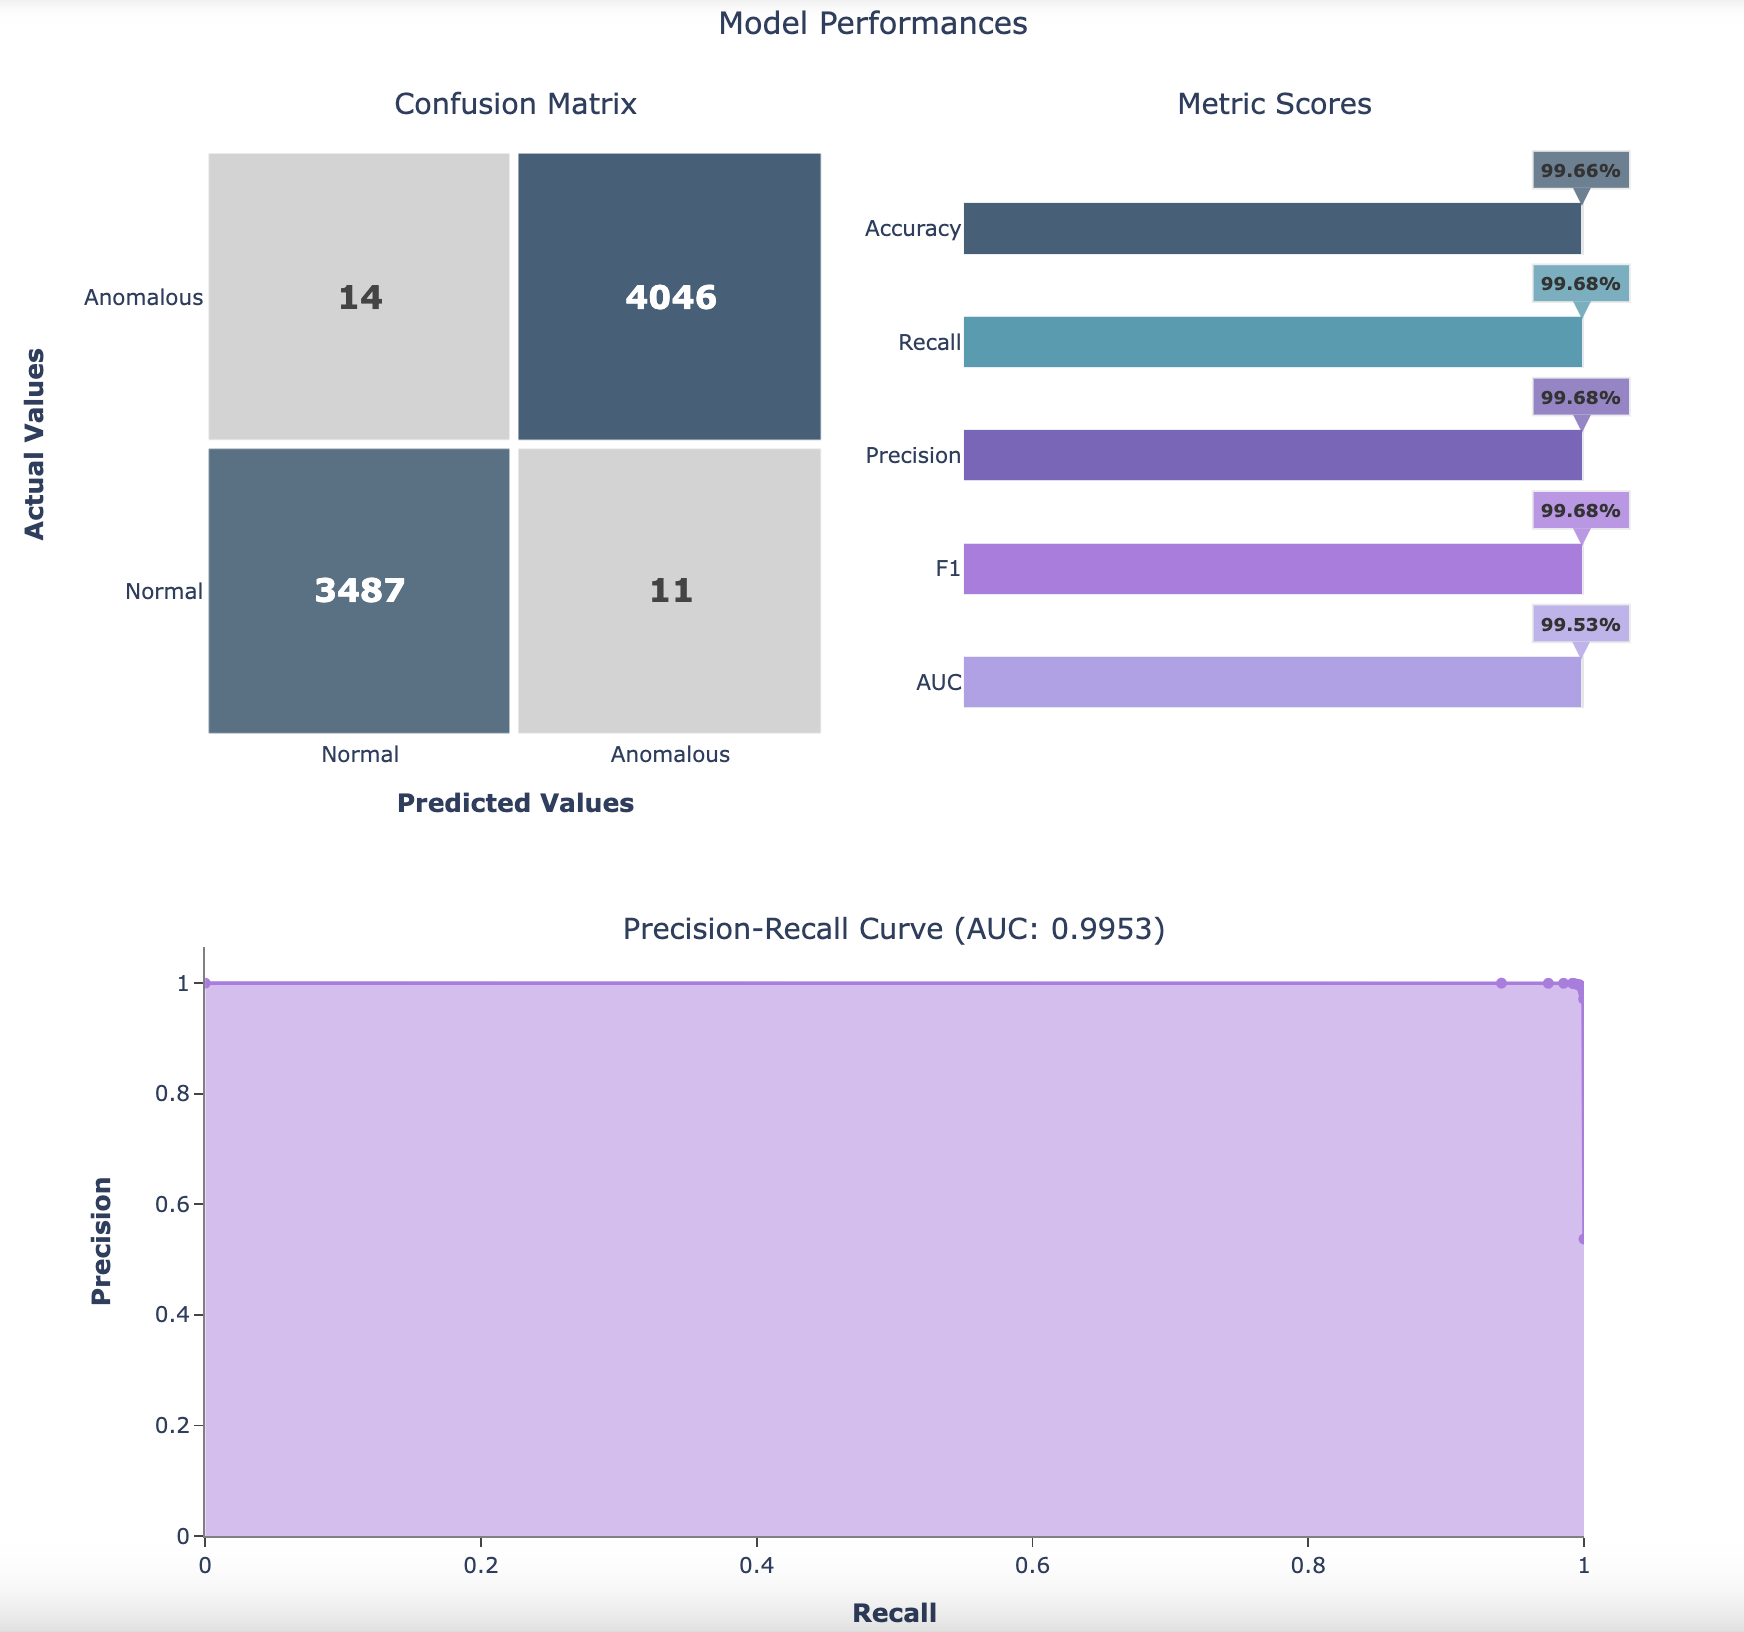

In [31]:
from IPython import display
display.Image("img/instrusion.png")

# Conclusion 

In [30]:
y_test.value_counts()

1    4060
0    3498
Name: class, dtype: int64

The test data set had 4060 examples of network traffic anomalous activity and 3498 examples of traffic with normal activity. 

Of the model classified the anomalous activity inocrreclty 14 times and the normal activity incorrectly 18 times, resulting in an accuracy score of 99.6%. 